# Ex11 Unsupervised learning: clustering

Unsupervised learning algorithms can learn patterns about the input data when there is no output variable associated to each observation (e.g. membership to a particular class, like a type of cancer, or a continuous variable, such as the catalytic rate of an enzyme). Unsupervised learning methods can help us to explore the data and identify patterns in it.

In the last exercise we focused on dimensionality reduction to explore the data and being able to visualize it. In this exercise we will focus on clustering of the data, using various clustering methods. The clustering will give us insight into the patterns in our data. 

We will focus on two common clustering methods (although there are many many more available):
    <br>- **Hierarchical clustering**  
     - **K-means clustering**

We will work with single-cell RNA sequencing data from immune cells treated with interferon. The data is from this paper: https://www.nature.com/articles/nbt.4042#Sec22.

# 0. Setup

## 0.1 Setup - Loading of packages and data
The packages and files are again loaded as in the last exercise. 

In [1]:
from scipy.io import mmread
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import scipy as sp
import statistics
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


# read the count matrix
control = sc.read_mtx("GSM2560248_2.1.mtx.gz") 
interferon = sc.read_mtx("GSM2560249_2.2.mtx.gz")

# read the barcodes - each barcode corresponds to a single cells
barcodesControl = pd.read_csv('GSM2560248_barcodes.tsv', sep='\t', header=None)
barcodesInterferon = pd.read_csv('GSM2560249_barcodes.tsv', sep='\t', header=None)

# transpose the count matrices (this will change them to cells x genes)
control = control.transpose()
interferon = interferon.transpose()

# read the gene information
genes = pd.read_csv('GSE96583_batch2.genes.tsv', sep='\t', header=None)

# add genes as variable names and make sure the names are unique
control.var_names = genes.iloc[:,1].to_numpy()
interferon.var_names = genes.iloc[:,1].to_numpy()
control.var_names_make_unique()
interferon.var_names_make_unique()

# assign the barcodes as the observation names (i.e. cell names)
control.obs_names = barcodesControl.iloc[:,0].to_numpy()
interferon.obs_names = barcodesInterferon.iloc[:,0].to_numpy()

# add whether or not the cells were stimulated with interferon beta
control.obs["treatment"] = 'control'
interferon.obs["treatment"] = 'interferon'

# create AnnData format - this is a data format used very often in single cell RNA-Seq and some packages provide some utilities to work with this directly
allData = ad.concat({'control':control, 'interferon':interferon}, label="treatment")
allData.obs_names_make_unique()

# read the cell type annotation that was published in the paper - we will use this to look at what they called what cells in this and the next exercise
celltypedata = pd.read_csv('GSE96583_batch2_total_tsne_df.tsv', sep='\t')
celltypedata = pd.concat([allData.obs, celltypedata], axis=1, join="inner")

# some cells are lost - we would have to ask the authors of the paper why that is
cellpresence = []
for idx in range(len(allData.obs_names)):
    cellpresence.append(allData.obs_names[idx] in celltypedata.index)

# but we only keep the ones we find
allData = allData[cellpresence,:]
allData.obs = celltypedata

# in scRNA-Seq especially when doing droplet based scRNA-Seq, cells sometimes fuse together and then they have double the content, here we remove those
idx_singlet = ~allData.obs['multiplets'].str.contains('doublet')
allData_singlets = allData[idx_singlet]

# and then we remove cells with few genes, or genes that are only found in 3 or less cells (one could be more stringent :-))
sc.pp.filter_cells(allData_singlets, min_genes=200)
sc.pp.filter_genes(allData_singlets, min_cells=3)

# we normalise the data and log the counts
sc.pp.normalize_total(allData_singlets, target_sum=1e4)
sc.pp.log1p(allData_singlets)

# just in case, we add the raw data to this AnnData data format too - one never knows if one wants to go back and to sth differently
allData_singlets.raw = allData_singlets

# and then we scale the data, in scanpy, the package we are using here, the standard deviation of a gene >10 gets clipped - in Seurat, a different workflow, this is not done and can lead to differences as pointed out in a recent preprint
sc.pp.scale(allData_singlets, max_value=10)

# for the exercise, at least in this part, we use the gene expression dataframe and the meta data later
# in principle this is not necessary, but we want you to learn PCA, t-SNE and UMAP using common tools and not only scRNA/scanpy specific tools
gene_expression_df = pd.DataFrame(allData_singlets.X, index=allData_singlets.obs_names, columns=allData_singlets.var_names)
meta_df = pd.DataFrame(allData_singlets.obs)

/home/valentina/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/valentina/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


# 1. Hierarchical clustering
## 1.1 Clustering of samples
To get started with clustering, we will first group the single-cell data into data per sample (also called pseudobulk data). In the paper, they included 8 patients and they measured the gene expression for both untreated and treated samples. Therefore, in total we can combine the single-cell data into 16 samples. 

**Question 1**: How would you expect the samples to cluster? 

In [2]:
#create bulk data from single-cell data by taking the mean over all cells of a sample
bulkallscaled = pd.DataFrame()
bulkall = pd.DataFrame()
for sampleid in np.unique(allData_singlets.obs['ind']):
    for treatmenttype in np.unique(allData_singlets.obs['treatment']):
        cellboolean = np.isin(allData_singlets.obs_names, allData_singlets.obs[np.logical_and(allData_singlets.obs['ind'].to_numpy() == sampleid, allData_singlets.obs['treatment'].to_numpy() == treatmenttype)].index)
        samplename = str(sampleid) + treatmenttype
        bulkall = pd.concat([bulkall, pd.DataFrame({samplename:allData_singlets.raw[cellboolean,:].X.A.mean(axis = 0)})], axis=1)
        bulkallscaled = pd.concat([bulkallscaled, pd.DataFrame({samplename:allData_singlets[cellboolean,:].X.mean(axis = 0)})], axis=1)

#assign gene names to rows
bulkall.index = allData_singlets.var_names
bulkallscaled.index = allData_singlets.var_names

For the hierarchical clustering, we can use different methods to calculate the distance between pairs of objects and between the clusters themselves. Here we will use correlation as distance measure between the pairs and complete linkage for the distance between the clusters. 

The options for inter-cluster distance are:
- Single linkage: computes the minimum distance between clusters before merging them.
- Complete linkage: computes the maximum distance between clusters before merging them.
- Average linkage: computes the average distance between clusters before merging them.
- Centroid linkage: calculates centroids for both clusters, then computes the distance between the two before merging them.

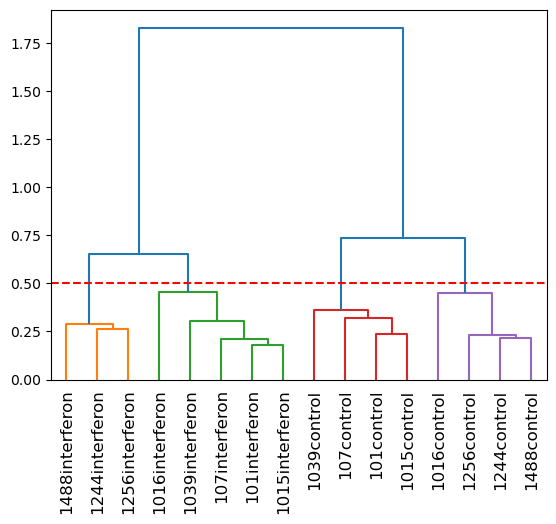

In [3]:
# Define distance methods
metric = "correlation"
method = "complete"

# Cluster the samples
col_linkage = sp.cluster.hierarchy.linkage(bulkallscaled.T, method=method, metric=metric)

# Define height to cut the tree
cutting_height = 0.5
dendrogram = sp.cluster.hierarchy.dendrogram(col_linkage, 
                                             color_threshold = cutting_height, 
                                             labels = bulkallscaled.keys(),
                                             leaf_rotation = 90)
plt.axhline(cutting_height,color='red',ls='--')

**Question 2**: Where would you cut the tree to split the samples into treated and untreated samples? You can try different cutting heights to visualize it in the previous plot.

**Question 3**: How do you interpret the subclustering within the clusters containing either treated or untreated samples?

## 1.2 Clustering of features (genes)
Using the bulk data, we can also cluster the genes based on their expression pattern across the samples. This is harder to visualize as we have >15,000 genes. Therefore, we will focus on the genes with a high variance across the samples as these will be the more interesting ones.

In [4]:
# Extract genes with a high variance across the samples
highVarianceGenes = bulkallscaled.index[bulkallscaled.apply(statistics.variance, axis=1) > 0.05]

In [5]:
# Cluster genes
metric = "correlation"
method = "average"

row_linkage = sp.cluster.hierarchy.linkage(bulkallscaled.loc[highVarianceGenes], method=method, metric=metric)

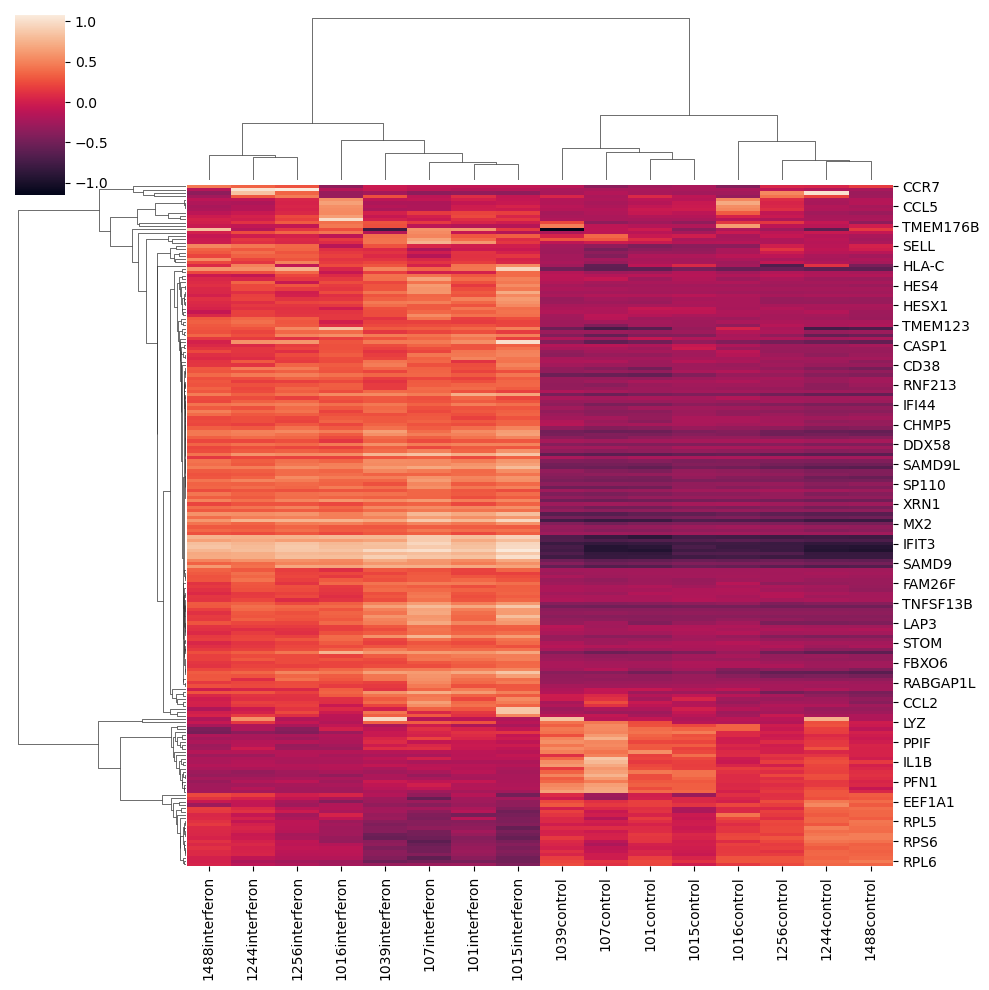

In [6]:
# Visualize gene clustering in heatmap
sns.clustermap(bulkallscaled.loc[highVarianceGenes],
               row_linkage=row_linkage, 
               col_linkage=col_linkage)

**Question 4**: What can you conclude from the gene clustering and how would you analyze what kind of genes cluster together? (think back to one of the previous exercise sessions)

**Question 5**: Try different inter-cluster distance metrics. Do you notice the differences between the clusters and dendrograms? 

## 1.3 Clustering of cells
We can also use the hierarchical clustering to cluster all the cells. In the last exercise session, we used the cell type labels from the paper to visualize the cell types on the dimensionality reductions. They use a different clustering algorithm in the paper so we will see if we can obtain similar clusters using hierarchical clustering.

In [7]:
# run PCA to obtain dimensionality reduction
sc.tl.pca(allData_singlets,n_comps=50)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752bc3357ce0>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

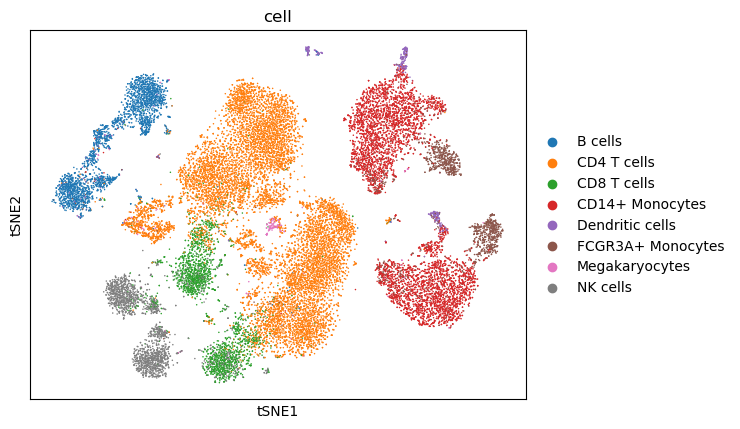

In [8]:
#Let's first plot the tsne again with the cell type labels from the paper.
sc.pp.neighbors(allData_singlets, n_neighbors=10, n_pcs=50)

perplexity_number = 30
sc.tl.tsne(allData_singlets, perplexity=perplexity_number, random_state=42)

sc.pl.tsne(allData_singlets, color = ['cell'])

In [9]:
# We will use the clustering algorithm from sklearn to reduce computing time for the hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
X_pca = allData_singlets.obsm['X_pca'] 
# We take the same number of clusters as the number of cell types that were identified in the paper
cluster = AgglomerativeClustering(n_clusters=8, metric='correlation', linkage='complete')
allData_singlets.obs['hclust_8'] = cluster.fit_predict(X_pca).astype(str) #we use the PCs instead of all genes to reduce computation time

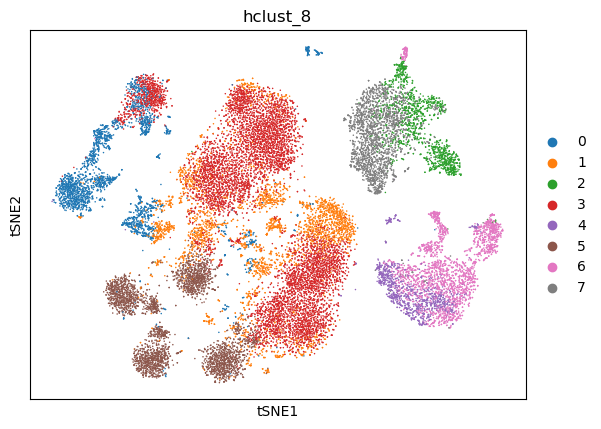

In [10]:
sc.pl.tsne(allData_singlets, color = ['hclust_8'])

**Question 6**: If we didn't know the number of cell types from the paper, how would you define the number of clusters to be chosen? 

The clustering is quite different from the cell types identified in the paper. This is probably because of the difference between clustering algorithms. However, we could still try to optimize the hierarchical clustering.

**Question 7**: Which parameters can you change to optimize the hierarchical clustering?

# 2. K-means clustering
## 2.1 Defining the number of clusters

For k-means clustering we have to define the number of centroids before running the clustering. To find out which number of clusters is best, there are different metrics. One of these metrics in the silhouette score which calculates the similarity between datapoints (cells) within a cluster and datapoints between clusters. The goal is to have datapoints within a cluster to be close together and datapoints between clusters to be distant from each other. 

$$
S = (b-a)/max(a,b)
$$

where a is the mean intra-cluster distance and b is the mean nearest-cluster distance.

The Silhouette coefficient ranges between [-1,1], where -1 is the worst score and 1 is the best (dense, well separated clusters). Values around 0 indicate overlapping clusters. Negative values usually indicate that samples have been assigned to the wrong cluster, because a different cluster is actually more similar.

In the following plots, the y axis indicates the index of each sample for each cluster label and the x axis its corresponding silhouette coefficient. The red discontinuous line indicates the average Silhouette coefficient over all clusters.

**Question 7**: Try different numbers of clusters. What would be a reasonable pick? You can judge based on criteria like:

- Average silhouette coefficient over clusters
- Presence of clusters with below average silhouette coefficients
- Fluctuations within clusters

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752bb8b1d080>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752bb8b1d080>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

For n_clusters = 4 The average silhouette_score is : 0.20285285


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b9293b7e0>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b9293b880>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

For n_clusters = 8 The average silhouette_score is : 0.16283916


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b92899300>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b928991c0>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

For n_clusters = 12 The average silhouette_score is : 0.14608002


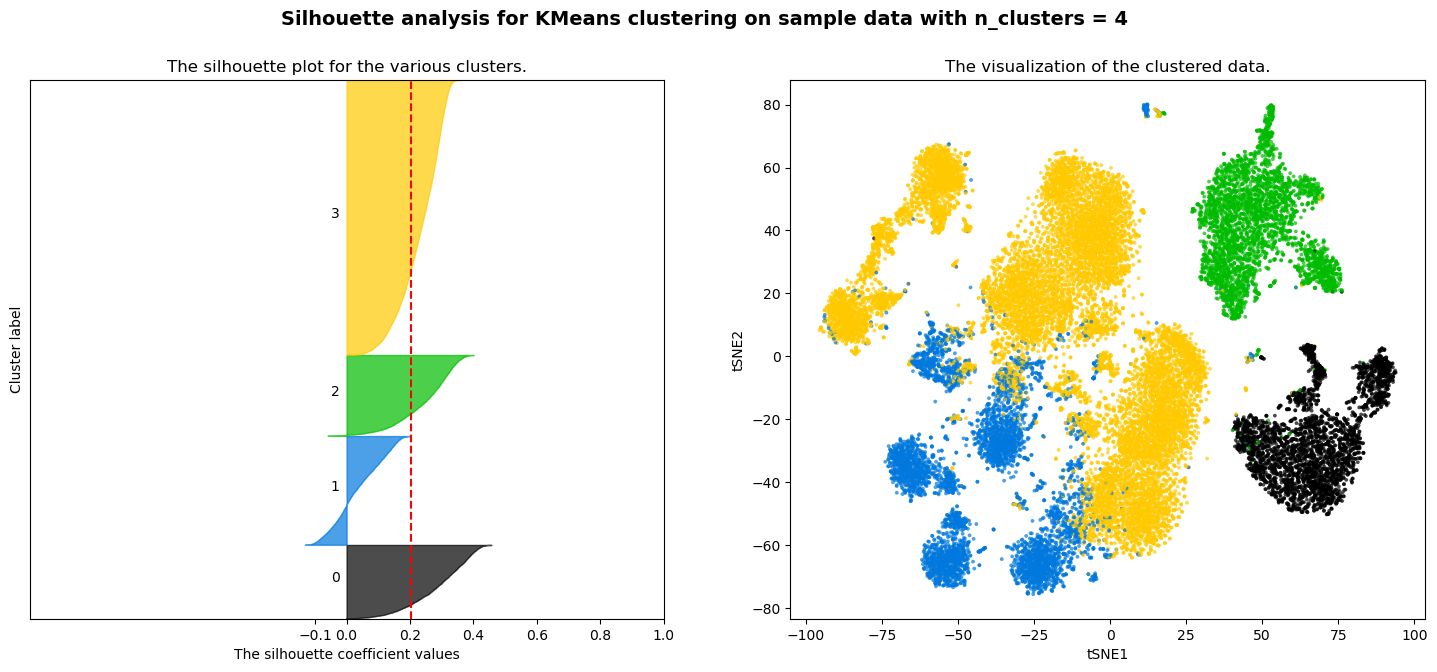

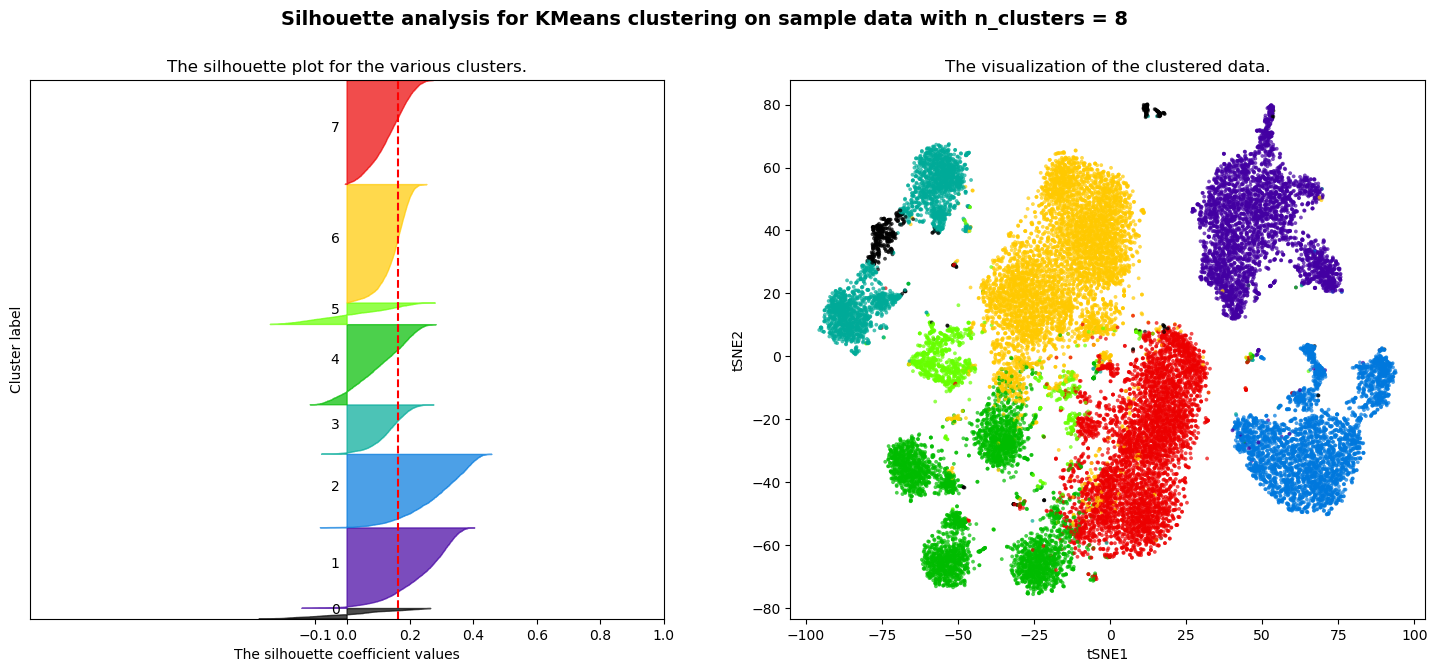

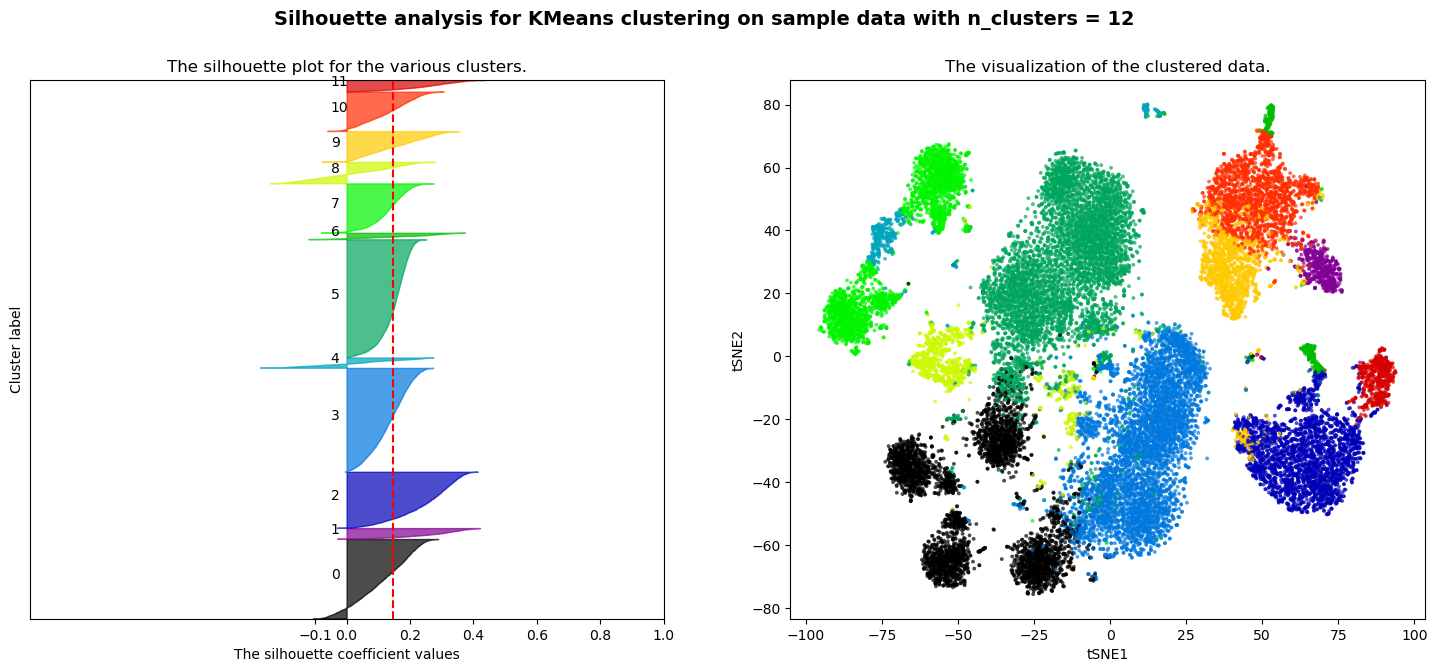

In [11]:
tsneDF = pd.DataFrame(allData_singlets.obsm['X_tsne'])

range_n_clusters = [4,8,12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsneDF.iloc[:,0],tsneDF.iloc[:,1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("tSNE1")
    ax2.set_ylabel("tSNE2")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

We still haven't found a similar clustering as shown in the paper. This is because there are many clustering algorithms out there and they are all optimized for different datasets. For example, Leiden graph-clustering is commonly used for clustering of single cells. 

**Question 8**: Imagine we performed the clustering like they did in the paper and we identified the 8 cell types. Next, we are interested in further studying the CD14+ monocytes and we wonder if there are still subgroups that we can identify within this cell type. Write pseudocode to further investigate the CD14+ monocytes using k-means clustering. 

In [12]:
#subset the data to only CD14+ monocytes
allData_CD14 = allData_singlets[allData_singlets.obs['cell'] == 'CD14+ Monocytes']

# rerun the PCA
sc.tl.pca(allData_CD14,n_comps=50)
X_pca_CD14 = allData_CD14.obsm['X_pca'] 

/home/valentina/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752bbfb26520>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

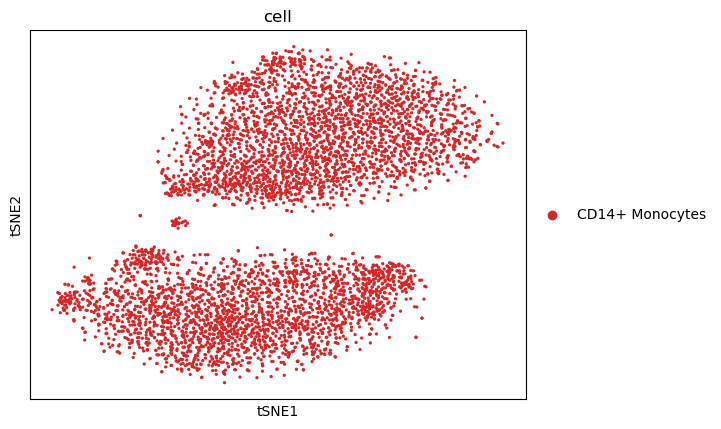

In [13]:
# perform tSNE for visualization
sc.pp.neighbors(allData_CD14, n_neighbors=10, n_pcs=50)

perplexity_number = 30
sc.tl.tsne(allData_CD14, perplexity=perplexity_number, random_state=42)

sc.pl.tsne(allData_CD14, color = ['cell'])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b92c607c0>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b92c607c0>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

For n_clusters = 2 The average silhouette_score is : 0.22221334


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b92fa5b20>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b92fa5b20>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

For n_clusters = 4 The average silhouette_score is : 0.07880738


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b92621e40>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x752b92621e40>
Traceback (most recent call last):
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/valentina/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object

For n_clusters = 6 The average silhouette_score is : 0.06188957


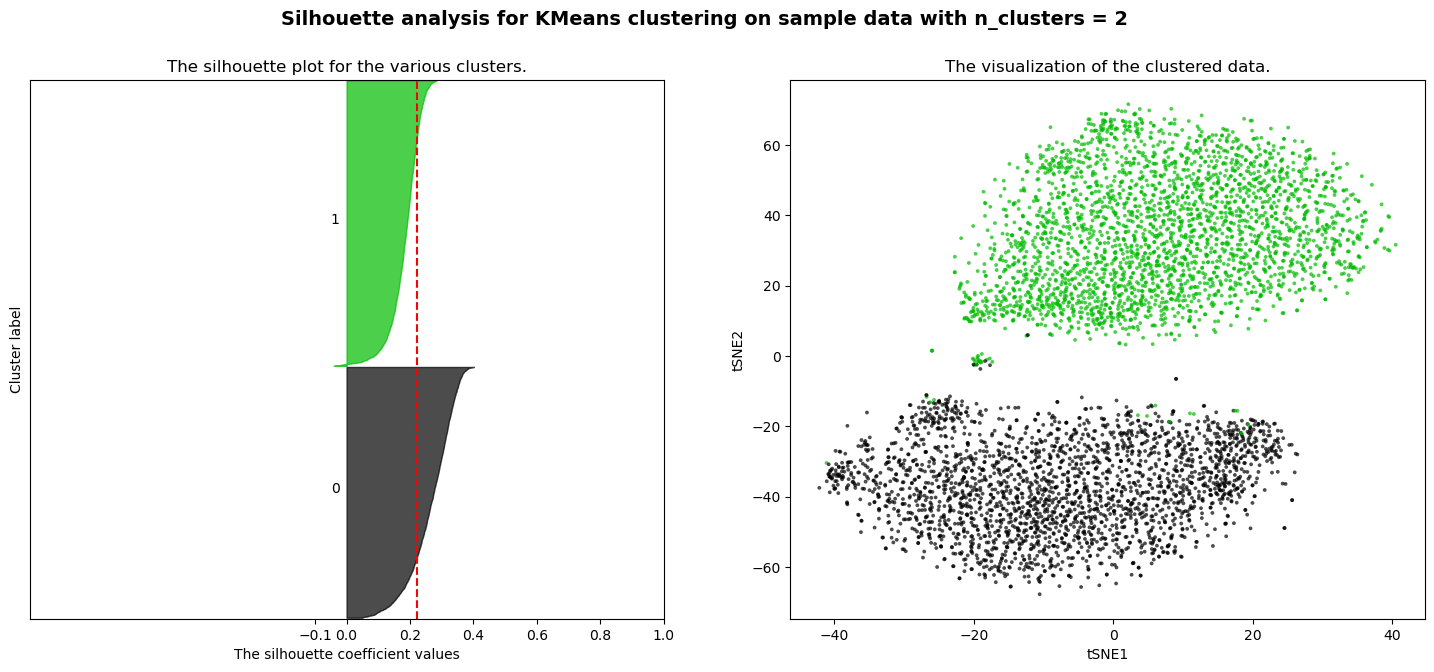

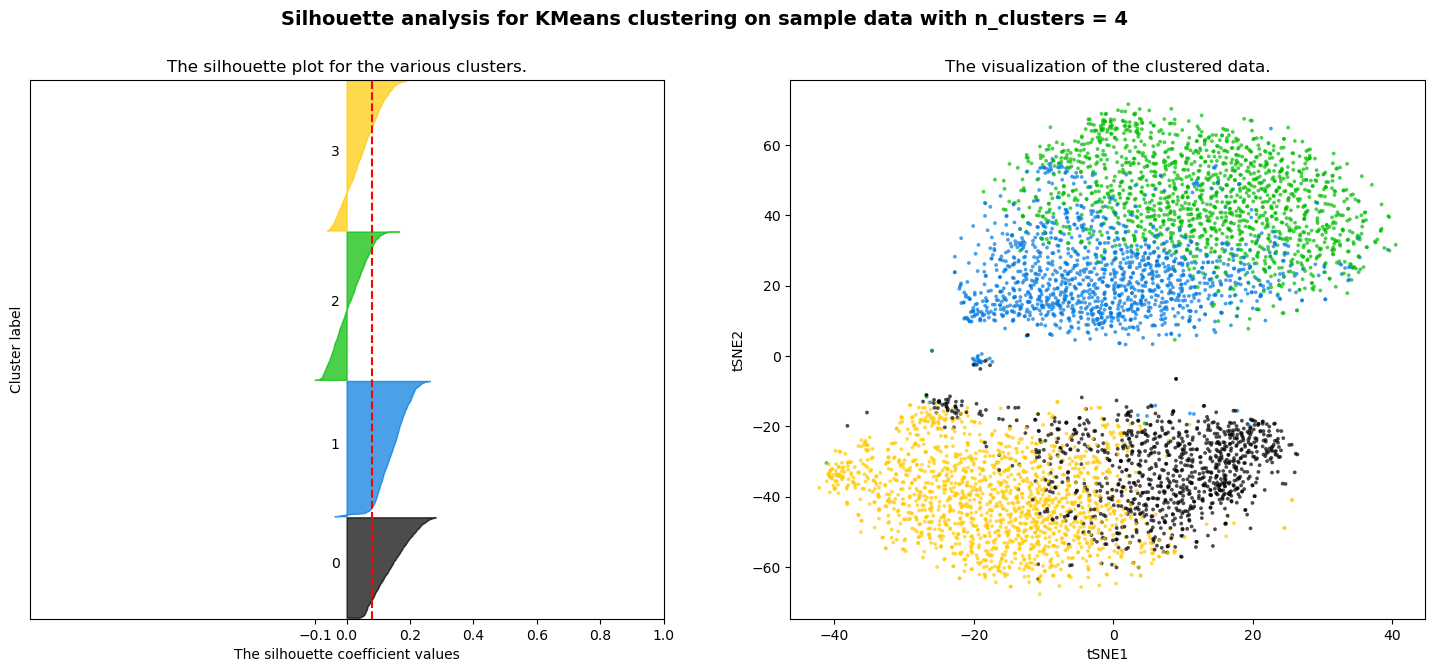

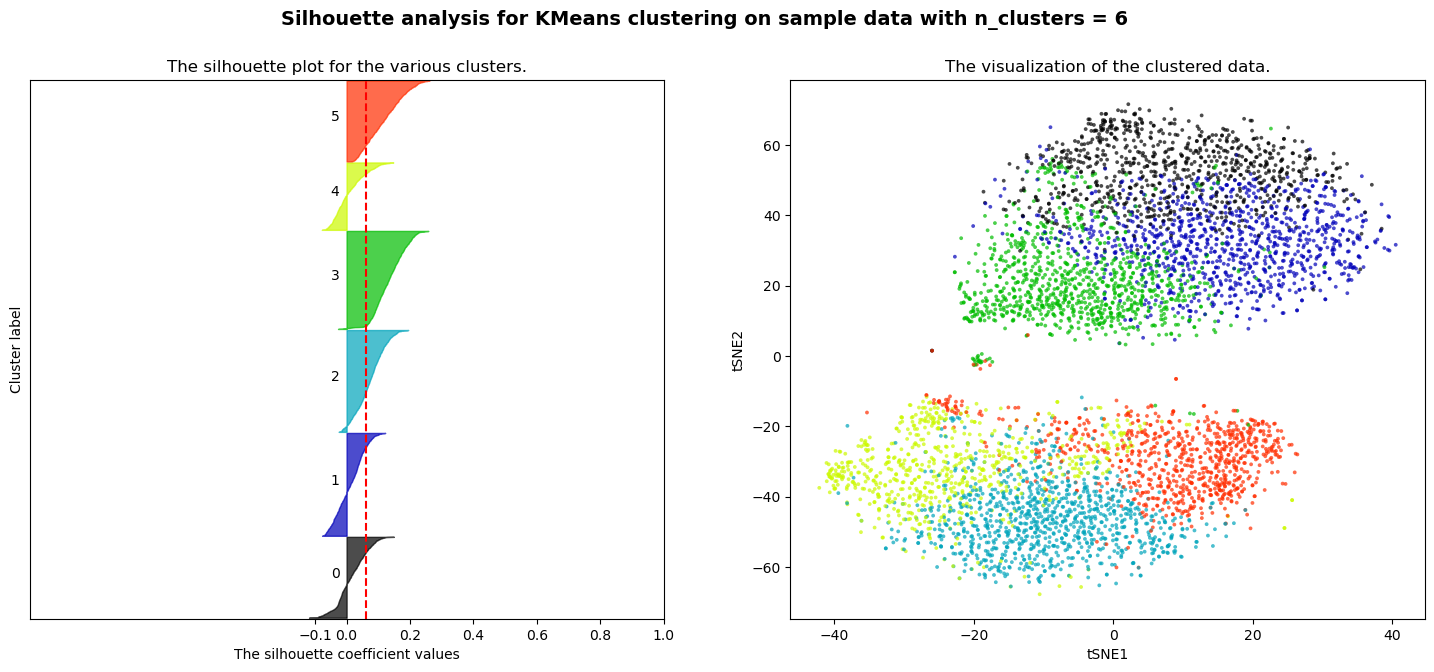

In [14]:
# calculate the silhouette scores for different numbers of centroids
tsneDF = pd.DataFrame(allData_CD14.obsm['X_tsne'])

range_n_clusters = [2,4,6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca_CD14) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(X_pca_CD14)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca_CD14, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca_CD14, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsneDF.iloc[:,0],tsneDF.iloc[:,1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("tSNE1")
    ax2.set_ylabel("tSNE2")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()